# Interactive Colormaps over a Data Map

This notebook will walk you though some of the possibilities for adding colormap options to your interactive data map. The main idea here is that often there is a lot of metadata associated to (or generated for) each point in a data map. Some of this data can be displayed via hover tooltips, or exposed via selection and filtering, but often the best option is to re-color the data map with respect to different metadata fields. Here we'll show you how to enable this for a viewer of a data map, allowing them to interactively select among different (pre-defined) fields and re-color the datamap on the fly. While the core functionality is fairly simple, there is a lot that can be achieved by combining options in various ways, so take this tutorial as inspiration rather than a complete set of examples. To get started we'll need to import DataMapPlot.

In [1]:
import datamapplot

Next we'll need some data, and preferably data for which we have some extra information available. We can make use of the CORD-19 dataset of scientific papers related to COVID-19 and SARS-CoV2 that we have used elsewhere since it has extra data such as the primary field of research, the number of citations, and the publication date available.

In [2]:
import numpy as np
import pandas as pd
import requests
import bz2
import io

base_url = "https://github.com/TutteInstitute/datamapplot"

data_map_file = requests.get(
    f"{base_url}/raw/main/examples/cord19_umap_vectors.npy"
)
cord19_data_map = np.load(io.BytesIO(data_map_file.content))
cord19_label_layers = []
for i in range(6):
    label_file = requests.get(
        f"{base_url}/raw/main/examples/cord19_layer{i}_cluster_labels.npy"
    )
    cord19_label_layers.append(
        np.load(io.BytesIO(label_file.content), allow_pickle=True)
    )
hover_text_file = requests.get(
    f"{base_url}/raw/main/examples/cord19_large_hover_text.txt.bz2"
)
cord19_hover_text = np.array([
    x.decode("utf-8").strip()
    for x in bz2.open(io.BytesIO(hover_text_file.content))
])
cord19_extra_data = pd.read_feather(f"{base_url}/raw/main/examples/cord19_extra_data.arrow")
date_file = requests.get(
    f"{base_url}/raw/main/examples/CORD19-subset-publish-dates.npy"
)
cord19_publication_date = np.load(io.BytesIO(date_file.content))

We'll start by making a relatively basic data map setting some basic customization options. That way we can have a starting point to see what the variations we will apply can look like.

<div class="alert alert-block alert-info">
<b>Tip:</b> Due to the larger datasets and a desire to keep the documentation pages smaller, this tutorial makes use of the <code>inline_data=False</code> directive to ensure all the data for all the plots are not embedded in a single page. This can cause issues, and does not work (for example) on Colab. If you are having issues running this notebook, try removing the <code>inline_data=False</code> keyword arguments and see if that helps! Also note that this means some of the exampes on the documentation page can take quite a while to load. Please be patient.</div>

<InteractiveFigure width=100% height=800>
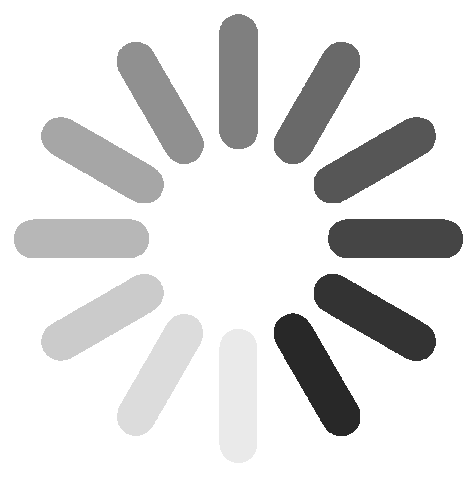

In [3]:
plot = datamapplot.create_interactive_plot(
    cord19_data_map,
    *cord19_label_layers,
    hover_text=cord19_hover_text,
    font_family="Cinzel",
    enable_search=True,
    inline_data=False,
    initial_zoom_fraction=0.9,
    offline_data_prefix="cord-large-cmaps-1",
)
plot

In previous tutorials we have added the ability to filter (using a histogram of data values) by some of the other fields such as the publication date. This is a very powerful tool, but it only supports a single metadata field at a time. Suppose we would like to be able to switch between looking at the map with respect to the primary field of study (a categorical array), the publication data (a datetime array) and the number of citations (a continuous array)? We can make this available to a viewer by setting the ``colormaps`` keyword argument to ``create_interactive_plot``. The ``colormaps`` argument takes a dictionary mapping names of fields to arrays of values. Each such array must have the same length (and be in the same order) as the points in the data map. Just adding this provices enough information for DataMapPlot to add a widget allowing a viewer to swap between different colormaps applied to the data map:

<InteractiveFigure width=100% height=800>
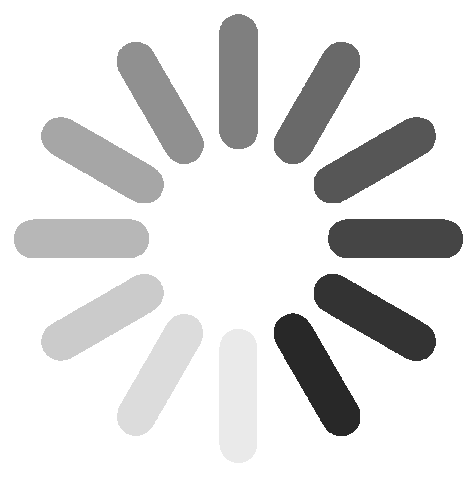

In [4]:
plot = datamapplot.create_interactive_plot(
    cord19_data_map,
    *cord19_label_layers,
    hover_text=cord19_hover_text,
    font_family="Cinzel",
    enable_search=True,
    inline_data=False,
    offline_data_prefix="cord-large-cmaps-2",
    initial_zoom_fraction=0.9,
    minify_deps=False,
    colormaps={"Date": cord19_publication_date, "Field": cord19_extra_data.primary_field, "Log10 Citations": np.log10(1 + cord19_extra_data.citation_count)},
)
plot

The menu in the bottom left allows a viewer to select from among the fields we provided, and recolors the data accordingly. Where possible DataMapPlot will add a colorbar or legend showing what values the chosen colormap corresponds to (try selecting different options from the menu to see examples). This works for continuous and datetime valued data, and for categorical data with twenty or less categories (the legend becomes to large and unwiedly for categorical data with too many categories). Furthermore, the generated legend for categorical data is interactive -- clicking on the color-swatch will toggle selection of data in that category (select the "Field" option and try clicking in the legend to see).

Now in this case DataMapPlot did all the heavy lifting and guessed data types and selected colormaps accordingly according to it's best guess for a suitable aesthetic. That may not be exactly what you are looking for. If you've read the other tutorials you'll know by now that as well as having easy to use defaults, DataMapPlot will provide some further options for customization. We would like to be able to select out of colormaps -- perhaps we have some specific palettes in mind (if the metadata was sentiment score, for example, then we would likely want to use a diverging colormap). Let's import seaborn to get access to its colormaps "rocket" and "mako" that pair well together and would be good choices for the citation count and publication date.

In [5]:
import seaborn as sns

Now we need to be able to tell DataMapPlot to use these colormaps. Since we need to be able to provide more information about each metadata field we'll need to use a different way to provide that information. We can make use, instead of ``colormaps`` which takes a dictionary, the pair of ``colormap_rawdata`` and ``colormap_metadata`` keyword arguments. The ``colormap_rawdata`` argument takes a list or arrays (or array-likes) -- the same things we were providing as the values of the dictionary we passed to ``colormaps``. We then pair this with ``colormap_metadata`` which takes a list of dictionaries, one for each array in ``colormap_rawdata``. These dictionaries provide extra information about each colormap, allowing more control. The required items in the dictionaries are:

* ``"field"`` -- which provides  ashort reference name for the array;
* ``"description"`` -- which provides a longer display name to be used to label the colormap in the drop down menu.

and optional items include:

* ``"cmap"`` -- which lets you specify the name of a ``cmap`` registered with matplotlib;
* ``"kind"`` -- which specifies the type of data, and should be one of ``"continuous"``, ``"datetime"`` or ``"categorical"``;
* ``"n_colors"`` -- which specifies how many color steps to show in the color-swatch preview of the colormap in the dropdown;
* ``"palette"`` -- which allows specification of a colormap via an explicit palette;
* ``"color_mapping"`` -- which allows specification of an explicit color-mapping of values to colors via a dictionary.

Note that at least one of ``"cmap"``, ``"palette"``, or ``"color_mapping"`` should be provided. Let's start with a basic usage where we will specify the colormaps to use for each of the fields. While the ``"kind"`` field is optional, it is often better to explicitly define it. Lastly, since we wil be using a colormap for the categorical data that can look like a continuous palette for the first four color steps, let's use a larger ``"n_colors"``. Note that DataMapPlot will take the maximum ``"n_colors"`` of any field and use that for all the colormaps, so we only need to specify it for one to get the job done.

<InteractiveFigure width=100% height=800>
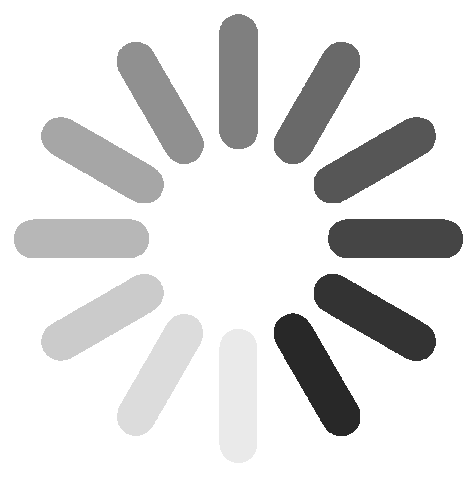

In [6]:
plot = datamapplot.create_interactive_plot(
    cord19_data_map,
    *cord19_label_layers,
    hover_text=cord19_hover_text,
    font_family="Cinzel",
    enable_search=True,
    inline_data=False,
    offline_data_prefix="cord-large-cmaps-3",
    initial_zoom_fraction=0.9,
    colormap_rawdata=[cord19_extra_data.primary_field, cord19_publication_date, np.log10(1 + cord19_extra_data.citation_count)],
    colormap_metadata=[
        {"field": "field", "description": "Primary Field", "cmap": "tab20b", "kind": "categorical", "n_colors": 8},
        {"field": "date", "description": "Date Published", "cmap": "rocket", "kind": "datetime"},
        {"field": "cites", "description": "log of Citation Count", "cmap": "mako", "kind": "continuous"}
    ]
)
plot

Now we see, in the drop down menu on the bottom left, that the color-swatch example uses eight colors, and we have custom colormaps selected for each of the fields. Note also that the items in the drop down appear in the order they were in the lists, so we have full control over the order of display. Lastly, note that with the approach we can specify longer descriptions of the metadata fields (the names given in the ``colormaps`` dict can be finicky as they are used for both the short field name and the description; if you are havign issues, try using the ``colormap_rawdata`` and ``colormap_metadata`` approach used here).

We managed to choose a long twenty color colormap for the categorical field data -- if we hadn't then colors would have simply been re-used for the fields. Of course some of those colors can be hard to distinguish, and perhaps we wanted to use a specific palette we generated ourselves rather than relying on something available in matplotlib's cmaps. To see this in action let's generate our own twenty color palette and use that instead.

How does one successfully build a palette of twenty colors that distinguishes between different categories as well as possible? Fortunately there is a library for that called ``glasbey`` that we will import.

In [7]:
import glasbey

To use glasbey we can simply call ``create_palette`` and tell it how many colors to create. It will then attempt to choose colors that are maximally distinguishable to human perception under some constraints. Here I will simply constrain the chroma and lightness of the colors produced, but we could alternatively requires the palette to be better for colorblind users, or have restricted hue ranges, etc.

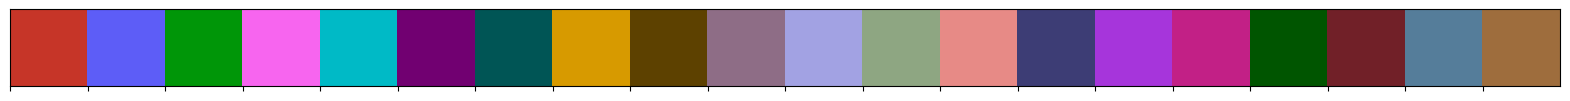

In [8]:
sns.palplot(glasbey.create_palette(20, chroma_bounds=(20,75), lightness_bounds=(20,60)))

Now that we have a palette (as a list of hexstrings of colors), we need to pass this in to DataMapPlot. TO do this we proceed exactly as before, except when specifying ``colormap_metadata`` we use ``"palette"`` instead of ``"cmap"`` and provide the list of colors. 

In [ ]:
palette = glasbey.create_palette(20, chroma_bounds=(20,75), lightness_bounds=(20,60))
plot = datamapplot.create_interactive_plot(
    cord19_data_map,
    *cord19_label_layers,
    hover_text=cord19_hover_text,
    font_family="Cinzel",
    enable_search=True,
    inline_data=False,
    offline_data_prefix="cord-large-cmaps-4",
    initial_zoom_fraction=0.9,
    colormap_rawdata=[cord19_publication_date, np.log10(1 + cord19_extra_data.citation_count), cord19_extra_data.primary_field],
    colormap_metadata=[
        {"field": "date", "description": "Date Published", "cmap": "rocket", "kind": "datetime"},
        {"field": "cites", "description": "log of Citation Count", "cmap": "mako", "kind": "continuous"},
        {"field": "field", "description": "Primary Field", "palette": palette, "kind": "categorical", "n_colors": 8},
    ]
)
plot

Now you can see in the dropdown that the "Primary Field" option uses our custom color palette for the categorical data, including in the displayed legend if you select that colormap.

Of course the reality is that not all of these fields are entirely distinct. We can gather them into groups, and potentially color each group thematically. Likewise, since Medicine dominates the dataset we can potentially choose a more neutral color for that to do more to highlight other fields in the data. So, let's create our own custom color mapping, creating a dictionary from fields to colors:

In [ ]:
from matplotlib.colors import rgb2hex

In [ ]:
color_mapping = {}
color_mapping["Medicine"] = "#bbbbbb"
for key, color in zip(("Biology", "Chemistry", "Physics"), sns.color_palette("YlOrRd_r", 3)):
    color_mapping[key] = rgb2hex(color)
for key, color in zip(("Business", "Economics", "Political Science"), sns.color_palette("BuPu_r", 3)):
    color_mapping[key] = rgb2hex(color)
for key, color in zip(("Psychology", "Sociology", "Geography", "History"), sns.color_palette("YlGnBu_r", 4)):
    color_mapping[key] = rgb2hex(color)
for key, color in zip(("Computer Science", "Engineering", "Mathematics"), sns.color_palette("light:teal_r", 4)[:-1]):
    color_mapping[key] = rgb2hex(color)
for key, color in zip(("Environmental Science", "Geology", "Materials Science"), sns.color_palette("pink", 3), ):
    color_mapping[key] = rgb2hex(color)
for key, color in zip(("Art", "Philosophy", "Unknown"), sns.color_palette("bone", 3)):
    color_mapping[key] = rgb2hex(color)

We pass this in by providing a ``"color_mapping"`` instead of ``"palette"``. This provides us even more control, allowing a specific fixed mapping of categories to colors:

In [ ]:
plot = datamapplot.create_interactive_plot(
    cord19_data_map,
    *cord19_label_layers,
    hover_text=cord19_hover_text,
    font_family="Cinzel",
    enable_search=True,
    inline_data=False,
    offline_data_prefix="cord-large-cmaps-5",
    initial_zoom_fraction=0.9,
    colormap_rawdata=[cord19_publication_date, np.log10(1 + cord19_extra_data.citation_count), cord19_extra_data.primary_field],
    colormap_metadata=[
        {"field": "date", "description": "Date Published", "cmap": "rocket", "kind": "datetime"},
        {"field": "cites", "description": "log of Citation Count", "cmap": "mako", "kind": "continuous"},
        {"field": "field", "description": "Primary Field", "color_mapping": color_mapping, "kind": "categorical", "n_colors": 8},
    ]
)
plot

Of course if we are lazy and don't want to carefully hand construct such a custom block color palette, we could ask ``glasbey`` to do it for us:

In [ ]:
palette = glasbey.create_block_palette([3,4,3,3,3,3], generated_color_chroma_bounds=(40,80), generated_color_lightness_bounds=(40,60), sort_block_sizes=False, lightness_bend_scale=5.5)
color_mapping = {}
color_mapping["Medicine"] = "#bbbbbb"
color_mapping |= dict(zip(
    [
        "Biology", "Chemistry", "Physics",
        "Psychology", "Sociology", "Geography", "History",
        "Business", "Economics", "Political Science",
        "Computer Science", "Engineering", "Mathematics",
        "Environmental Science", "Geology", "Materials Science",
        "Art", "Philosophy", "Unknown",
    ],
    palette
))

plot = datamapplot.create_interactive_plot(
    cord19_data_map,
    *cord19_label_layers,
    hover_text=cord19_hover_text,
    font_family="Cinzel",
    enable_search=True,
    inline_data=False,
    offline_data_prefix="cord-large-cmaps-6",
    initial_zoom_fraction=0.9,
    colormap_rawdata=[cord19_publication_date, np.log10(1 + cord19_extra_data.citation_count), cord19_extra_data.primary_field],
    colormap_metadata=[
        {"field": "date", "description": "Date Published", "cmap": "rocket", "kind": "datetime"},
        {"field": "cites", "description": "log of Citation Count", "cmap": "mako", "kind": "continuous"},
        {"field": "field", "description": "Primary Field", "color_mapping": color_mapping, "kind": "categorical", "n_colors": 8},
    ]
)
plot

This covers most of the core functionality available to providing custom colormaps, but there are obviously myriad ways you can use the options here to tweak things and obtain quite different results.